In [1]:
%matplotlib widget
import psycopg2
import numpy as np
import gower
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from tqdm.notebook import tqdm

from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Loading data

## Querying database

In [2]:
# Loading data
conn = psycopg2.connect(database="full_STUPS",
                        user="postgres",
                        host='localhost',
                        password="postgres",
                        port=5432)
cur = conn.cursor()
cur.execute( '''select distinct ep.*, id_lot
                from echantillon_propriete ep 
                inner join echantillon e on e.id = ep.id 
                inner join composition c on c.id = e.id_composition 
                inner join lot_complet lc on (lc.e1 = c.id or lc.e2 = c.id)
                order by id_lot''')
samples = cur.fetchall()
conn.commit()
conn.close()
colnames = [desc[0] for desc in cur.description]

## Preparing dataset

In [3]:
# Subsampling data
subsample = False

X = pd.DataFrame(list(samples), columns=colnames) 
y = X['id_lot']

X = X.drop(columns=['id', 'num_echantillon', 'id_lot'])

if subsample:
    X = X.iloc[:3750, :]
    
print(f'Samples shape : {X.shape}')

Samples shape : (1861, 52)


## Computing Gower distance

In [4]:
# Computing distance matrix between all samples
dist_matrix = gower.gower_matrix(X)
print(f'Distance matrix size : {dist_matrix.size}')

Distance matrix size : 3463321


## Computing t-SNE

In [5]:
# Computing t-SNE
tsne = TSNE(n_components=3,
            perplexity=50,
            init='random',
            metric='precomputed')
embedding = tsne.fit_transform(dist_matrix)

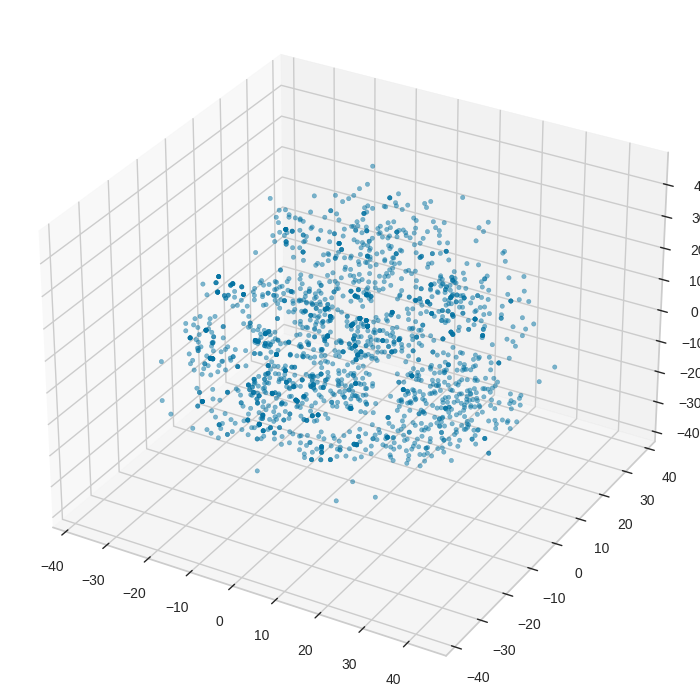

In [6]:
# Printing t-SNE results
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# plot
sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], s=10, marker='o',  alpha=0.5)

# Looking for the optimal number of clusters

## Computing score *k* different number of neighbors

In [7]:
# Computing different clustering using K-NN
# with different number of clusters

# TODO : séparer le jeu de données en jeu d'entraînement et de test

labels_results = []
scores = []
min_clusters = 1
nb_clusters = 100
nb_clusters_range = range(min_clusters, nb_clusters + min_clusters)

for i in tqdm(nb_clusters_range):
    knn = KNeighborsClassifier(n_neighbors=i).fit(embedding, y)
    labels = knn.predict(embedding)
    labels_results.append(labels)
    scores.append(knn.score(embedding, y))

  0%|          | 0/100 [00:00<?, ?it/s]

## Silhouette score curve

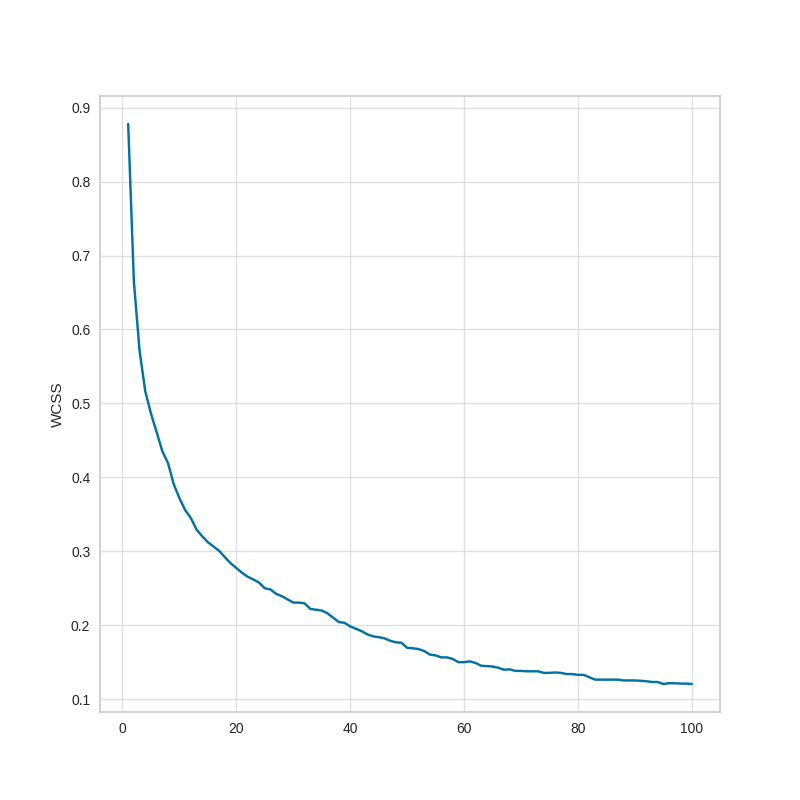

In [8]:
# Printing curve(s)
x = nb_clusters_range

fig = plt.figure(figsize=(8, 8))
plt.plot(x, scores)
#plt.plot(x, d_wcss)
#plt.plot(x, d2_wcss)
plt.ylabel('WCSS')

plt.grid(visible=True, alpha=0.6)
plt.show()

# Selecting optimal number of clusters

In [13]:
# Finding the optimal cluster number
index_cluster = np.argmax(scores)
optimal_hyperparameter_number = index_cluster + 1 # Indexes start at 0.
print(f'Optimal number of neighbors : {optimal_hyperparameter_number}. Score value : {np.max(scores)}')

Optimal number of neighbors : 1. Score value : 0.8780225685115529


# Printing cluster

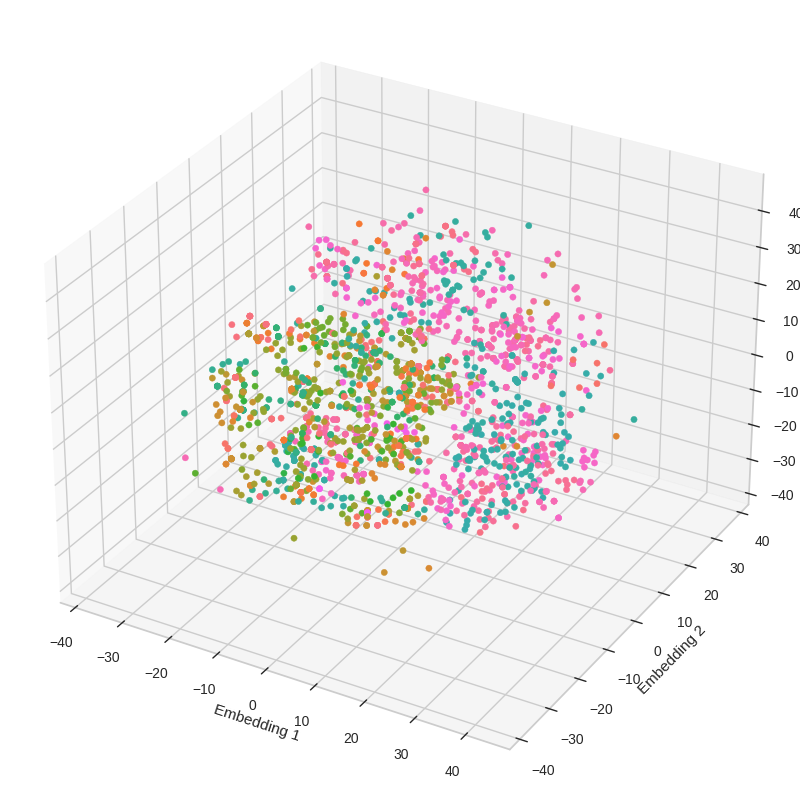

In [10]:
# Printing the cluster according to the optimal cluster number
cluster_labels = labels_results[optimal_hyperparameter_number]
embedding_df = pd.DataFrame({'x': embedding[:, 0],
                             'y': embedding[:, 1],
                             'z': embedding[:, 2],
                             'label': cluster_labels})

# axes instance
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig, auto_add_to_figure=False)

ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", len(np.unique(cluster_labels))).as_hex())

# plot
sc = ax.scatter(embedding_df.loc[:, 'x'], embedding_df.loc[:, 'y'], embedding_df.loc[:, 'z'], s=20, c=embedding_df.loc[:, 'label'], marker='o', cmap=cmap, alpha=1)

# Evaluating results

## Querying batches from database

In [11]:
conn = psycopg2.connect(database="full_STUPS",
                        user="postgres",
                        host='localhost',
                        password="postgres",
                        port=5432)
cur = conn.cursor()
cur.execute( '''with temp_e as (
            	select distinct lc.e1, lc.e2, lc.id_lot
            	from echantillon_propriete ep 
            	inner join echantillon e on e.id = ep.id 
            	inner join composition c on c.id = e.id_composition 
            	inner join lot_complet lc on (lc.e1 = c.id or lc.e2 = c.id)
            )
            select count(distinct e1) as cpt
            from temp_e
            group by id_lot
            ''')
distribution = cur.fetchall()
distribution = pd.DataFrame(list(distribution))
conn.commit()
conn.close()

## Printing histogram

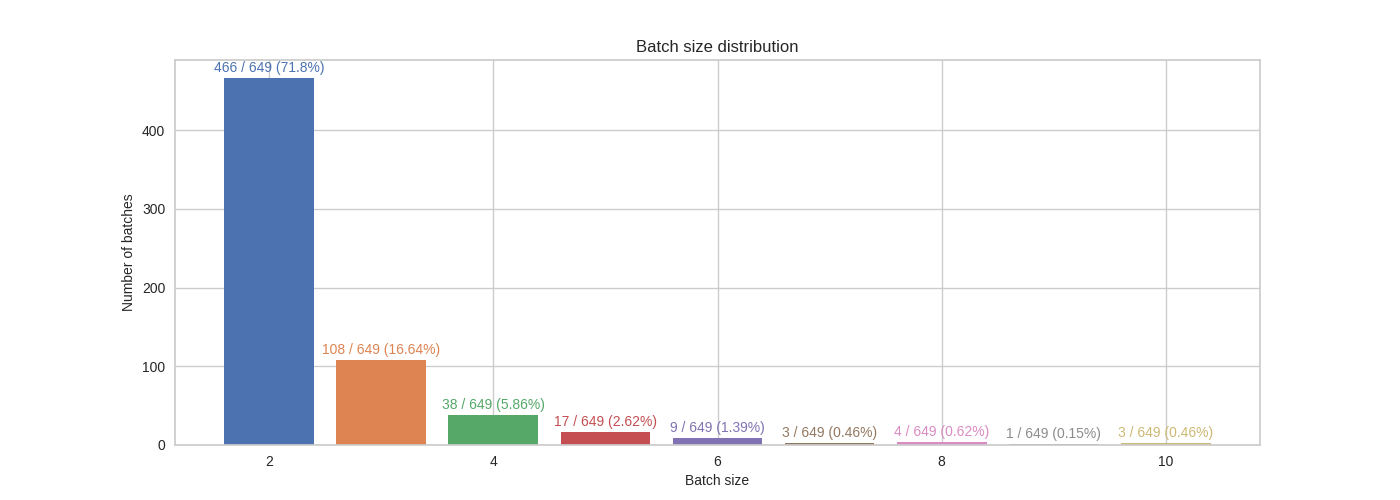

In [12]:
labels, counts = np.unique(distribution, return_counts=True)
total = np.sum(counts)

fig = plt.figure(figsize=(14,5))

colors = ListedColormap(sns.color_palette("deep", len(labels))).colors

for i in range(len(labels)):
    color=np.random.rand(4,4)
    plt.bar(labels[i], counts[i], align='center', color=colors[i])
    plt.annotate(f'{counts[i]} / {total} ({round(100.0 * counts[i] / total, 2)}%)', xy=(labels[i], counts[i]), color=colors[i],  fontsize=10, ha='center', xytext=(0, 6), textcoords='offset pixels')

plt.title('Batch size distribution', fontsize=12)
plt.xlabel('Batch size', fontsize=10)
plt.ylabel('Number of batches', fontsize=10)
plt.show()